# Sintonía de controladores PID con base en los modelos de curva de reacción


En esta práctica vamos a sintonizar y probar controladores PI y PID para los sistemas que usamos en el laboratorio, a saber:

+ El sistema térmico
+ Control de velocidad de un Motor D.C.
+ Control de Ángulo de un Motor D.C.

## 1. Configuración

---


### Instalación de las librerias unthermal y unmotor

Descomentar y ejecutar esta celda solo para instalar por primera vez o actualizar las librerias. __Asegúrese de instalar  [Git](https://git-scm.com/download/win/ "Git").__



In [11]:
#import subprocess
# command = ["pip", "install", "-I", "git+https://github.com/nebisman/UNThermal.git@main#subdirectory=code/python_code"]
# process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
# for line in process.stdout:
#     print(line.strip())

# command = ["pip", "install", "-I","git+https://github.com/nebisman/UNDCMotor.git@main#subdirectory=code/python_code"]
# process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
# for line in process.stdout:
#     print(line.strip())


### Importación de comandos de la libreria unthermal y unmotor

A continuación importamos los comandos básicos que usaremos de la libreria `unthermal` y la libreria `Matplotlib` para las figuras.

In [12]:
!pip install mplcursors 
#on error try:  !pip install mplcursors --user
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import unthermal as temp
import unmotor as motor



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



### Definición de los sistemas en el IoT

Lo primero que necesitamos es definir tanto el sistema térmico como el motor como sistemas IoT, a continuación.

In [13]:
mi_termico = temp.ThermalSystemIoT(plant_number = "PC-T-15" , broker_address = "192.168.1.100", port=1883)
mi_motor = motor.MotorSystemIoT(plant_number = "XXXX" , broker_address = "192.168.1.100", port=1883) 

## Sintonia de controladores PI con base en el modelo FOTD

---
### Breve teoría - control PID

Uno de los algoritmos de control más usuales en el control de sistemas en la industria es el control **PID**. Según varios estudios, el PID ocupa la más del 95% de los procesos industriales. En este tipo de control la señal de control aplicada es proporcional al **error** $e(t)$, a su integral  y a su derivada, según la expresión:
\begin{align*}
u(t) &= P + I + D\\
u(t) &= k_p\,e(t) + k_i\,\int_0^t{e(\lambda)\,d\lambda} + k_d\, \dfrac{de(t)}{dt}
\end{align*}

La estructura del controlador se muestra en la figura siguiente:

<img src="https://github.com/nebisman/UNThermal/blob/main/code/python_code/notebooks_lab_2024_2/pid1gdl.png?raw=true" alt="PID" width="500"/>

Note que las constantes $k_p$, $k_i$ y $k_d$ dan peso a cada una de las diferentes acciónes. Así por ejemplo, de definen:

+ *Un controlador **P** o proporcional puro*, si $k_p\neq 0$, pero $k_i=k_d=0$ 
+  *un controlador **PI** o proporcional integral, si $k_p\neq 0$ y $k_i\neq 0$*

### Sintonía según el método de Ziegler-Nichols por respuesta al escalón

El método más antiguo para *sintonizar* un PID, es decir, de ajustar empiricamente las constantes de un controlador PID es el método de la respuesta al escalón de **Ziegler y Nichols (1948)**. Según este método, para un controlador unicamente proporcional (P) o uno proporcional e integral (PI), las constantes $k_p$ y $k_i$ se ajustan, respectivamente, de acuerdo con la tabla siguiente.


| **Tipo de Controlador** | **Ganancia Proporcional** $k_p$                | **Ganancia Integral** $k_i$                | 
|-------------------------|------------------------------------------------|--------------------------------------------|
| **P** solo proporcional                    | $\dfrac{\tau}{\alpha L}$                 | $0$                                  | 
| **PI** proporcional e integral                  | $0.9 \times \dfrac{\tau}{\alpha L}$      | $ \dfrac{0.3 \, \tau}{\alpha \, L^2}$ |


Note que los parámetros del controlador se expresan en términos de las constantes $\alpha$, $\tau$ y $L$ obtenidas experimentalmente a partir de un modelo **FOTD** tal como el de la práctica anterior, es decir, por medio de las constantes del siguiente modelo:

$$G(s)=\frac{\alpha}{\tau\,s+1} e^{-L\,s}$$

Cuya respuesta se ilustra en la siguiente figura: 

<img src="https://github.com/nebisman/UNThermal/blob/main/code/python_code/notebooks_lab_2024_2/primer_orden_explained.png?raw=true" alt="Gráfica de resultados" width="500"/>











Una descripción detallada de los métodos de sintonía la encuentra en el capítulo 6 del libro de **Control PID Avanzado** de la bibliografía. En [este fragmento](https://drive.google.com/file/d/1QwG9kX1Oqav6lfPNQsxBqlAMWaGTstdD/view?usp=sharing) se presenta especifícamente el método de Ziegler y Nichols.  

Un compendio abundante de métodos de sintonia para diferentes procesos se puede encontrar [en este manual](https://drive.google.com/file/d/1GA3vUVPkJSxrjMnHN46nfjszPMrXoqCo/view?usp=sharing). 


A continuación vamos a ver la respuesta en lazo cerrado del sistema térmico con un controlador PI, siguiendo el método de Ziegler-Nichols.


Successfully connected to MQTT Broker 192.168.1.100
Command send:  13
PID parameters changed
Successfully connected to MQTT Broker 192.168.1.100
Subscribed:  14   (2,)
Command send:  15


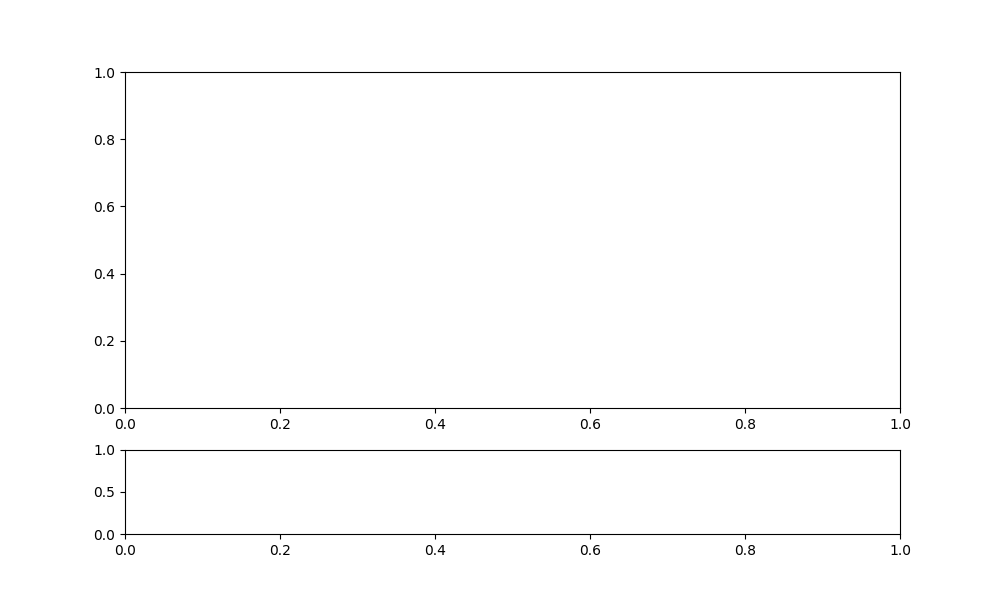

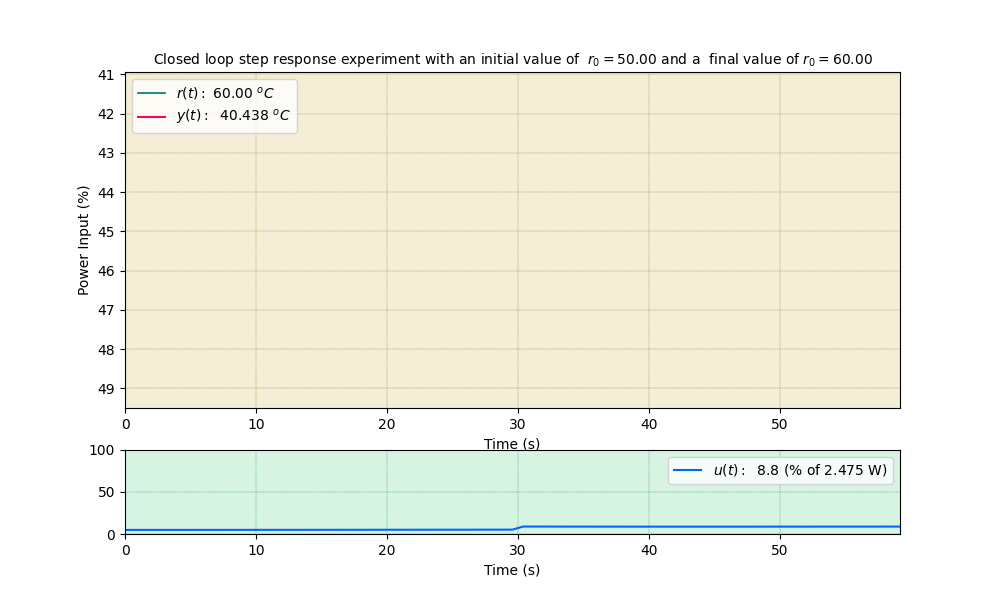

In [18]:
# Reglas de Ziegler - Nichols para un controlador PI
# Aqui ponemos los parámetros del modelo que obtuvimos en nuestro experimento, use el modelo a 60° de la práctica anterior.

alfa = 1.28
tau = 37.13
L = 71.75

# Calculamos las constantes según el método de Ziegler-Nichols

kp_zn = 0.9*tau / (alfa * L)  # constante proporcional
ki_zn = 0.3*tau / (alfa * L**2) # constante integral 

# programamos los parámetros del PID con el siguiente comando
temp.set_pid(mi_termico, kp=kp_zn, ki=ki_zn, kd=0, beta=1)


r0 = 50 # valor inicial del escalón de referencia antes del cambio (grados celsius)
r1 = 60 # valor final del escalón de referencia  (grados celsius)
t0 = 30 # tiempo que dura en el valor inicial
t1 = 30 # tiempo que demora en el valor final

# con este comando obtenemos la respuesta al escalón
t_zn, r_zn, y_zn, u_zn = temp.step_closed(mi_termico,r0=r0, r1=r1, t0=t0, t1=t1)


plt.savefig("grafica_zn.png", format="png", bbox_inches="tight") # para salvar la figura
plt.show() # para congelarla en el notebook

### Otros métodos de sintonía 

Existen una infinidad de métodos de sintonía. Con base en propuesta original de Ziegler y Nichols han seguido apareciendo nuevas propuestas de sintonía que preservan la filosofía del método original en cuanto a su simplicidad (solo se requiere hacer un modelo aproximado de primer orden del proceso). La tabla siguiente contiene algunos métodos de sintonización reportados en la literatura para controladores PI.

| **Propuesto por** | **Ganancia Proporcional** $k_p$                | **Ganancia Integral** $k_i$                | 
|-------------------------|------------------------------------------------|--------------------------------------------|
| **Skogestad (2003)**           |   $\dfrac{0.5\,\tau}{\alpha\,L}$   | $\dfrac{k_p}{\min(\tau, 8\,L)}$ |
| **Zhang  (1994)**           |   $\dfrac{\tau}{\alpha\,L}$  | $\tau$|
|**Åström and Hägglund (2006)**                | $\dfrac{0.15}{\alpha} + \left(0.35 - \dfrac{L \cdot \tau}{(L + \tau)^2}\right) \dfrac{\tau}{\alpha \cdot L} $               |  $\dfrac{k_p}{0.35 \cdot L + \frac{13 \cdot L \cdot \tau^2}{\tau^2 + 12 \cdot L \cdot \tau + 7 \cdot L^2}}$   |

### Trabajo experimental con el sistema térmico

Realice los siguientes experimentos con un escalón que cambia desde `r0=50` a `r1=60`.  Para los 2 experimentos use nombres diferentes en las variables de salida para poder después graficarlos conjuntamente. Por ejemplo, para el experimento 1 (valores de Skogestad) puede usar:

`t_sk, r_sk, y_sk, u_sk = temp.step_closed(mi_termico,r0=r0, r1=r1, t0=t0, t1=t1)`


1. Sintonice un controlador PI por el método de Skogestad y obtenga la respuesta al escalón en lazo cerrado.

1. Sintonice un controlador PI por el método de Åström and Hägglund y obtenga la respuesta al escalón en lazo cerrado.

Successfully connected to MQTT Broker 192.168.1.100
Command send:  7
PID parameters changed
Successfully connected to MQTT Broker 192.168.1.100
Subscribed:  8   (2,)
Command send:  9


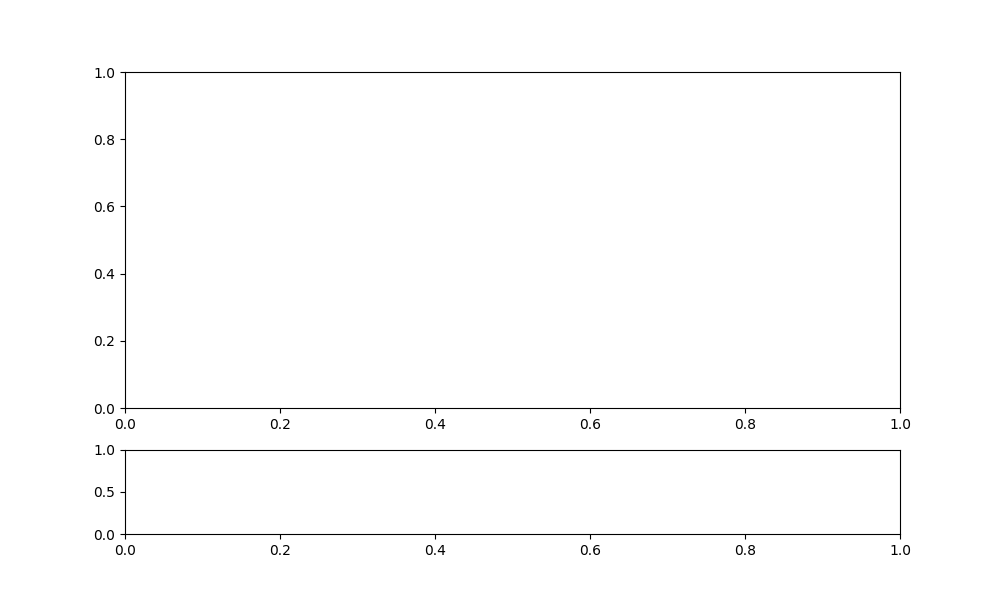

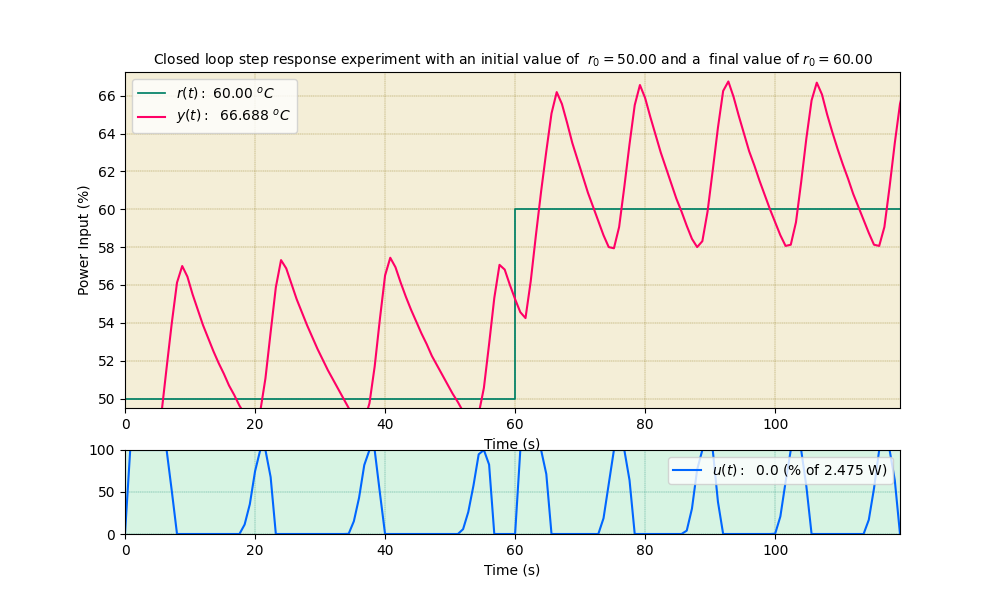

In [16]:
# Reglas de Skogestad para un controlador PI
# Aqui ponemos los parámetros del modelo que obtuvimos en nuestro experimento, use el modelo a 60° de la práctica anterior.

alfa = 1.28
tau = 37.13
L = 71.75

# Calculamos las constantes según el método de skogestad

kp_sk = 0.5*tau / (alfa * L)  # constante proporcional
ki_sk = min(tau, 8*L) # constante integral 

# programamos los parámetros del PID con el siguiente comando
temp.set_pid(mi_termico, kp=kp_sk, ki=ki_sk, kd=0, beta=0)


r0 = 50 # valor inicial del escalón de referencia antes del cambio (grados celsius)
r1 = 60 # valor final del escalón de referencia  (grados celsius)
t0 = 30 # tiempo que dura en el valor inicial
t1 = 30 # tiempo que demora en el valor final

# con este comando obtenemos la respuesta al escalón
t_sk, r_sk, y_sk, u_sk = temp.step_closed(mi_termico,r0=50, r1=60, t0=60, t1=60)

plt.savefig("grafica_sk.png", format="png", bbox_inches="tight") # para salvar la figura
plt.show() # para congelarla en el notebook

Successfully connected to MQTT Broker 192.168.1.100
Command send:  10
PID parameters changed
Successfully connected to MQTT Broker 192.168.1.100
Subscribed:  11   (2,)
Command send:  12


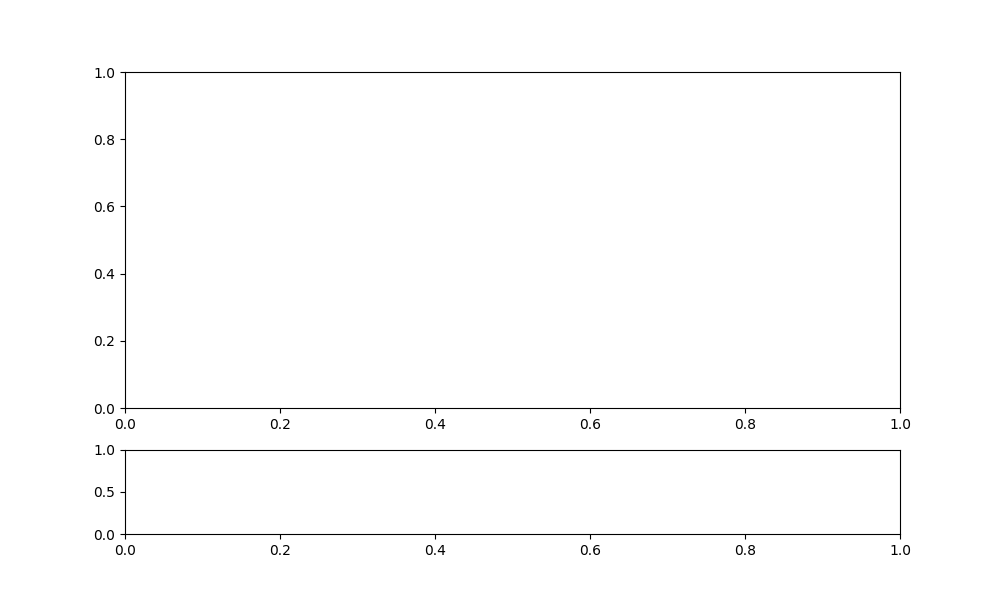

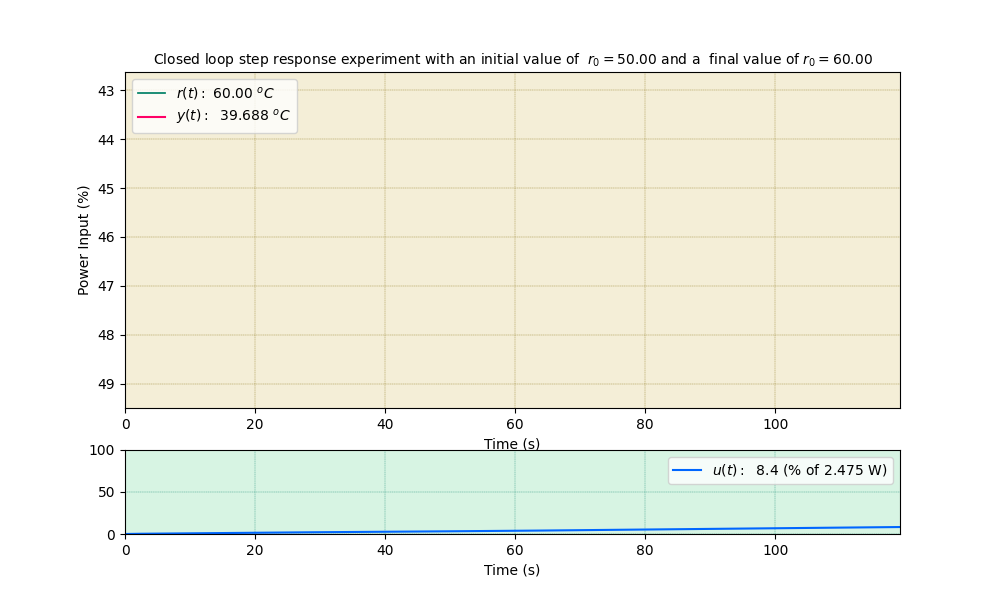

In [17]:
# Reglas de Astrom y Hagglund para un controlador PI
# Aqui ponemos los parámetros del modelo que obtuvimos en nuestro experimento, use el modelo a 60° de la práctica anterior.

alfa = 1.28
tau = 37.13
L = 71.75

# Calculamos las constantes según el método

kp_ah = (0.15 / alfa ) + ( 0.35 - (( L * tau ) / ( L + tau )**2 )) * (tau / ( alfa * L)) # constante proporcional
ki_ah = kp_ah / ( 0.35 * L + ( 13 * L * tau**2) / ( tau**2 + 12*L*tau + 7*L**2 )) # constante integral 

# programamos los parámetros del PID con el siguiente comando
temp.set_pid(mi_termico, kp=kp_ah, ki=ki_ah, kd=0, beta=0)


r0 = 50 # valor inicial del escalón de referencia antes del cambio (grados celsius)
r1 = 60 # valor final del escalón de referencia  (grados celsius)
t0 = 30 # tiempo que dura en el valor inicial
t1 = 30 # tiempo que demora en el valor final

# con este comando obtenemos la respuesta al escalón
t_ah, r_ah, y_ah, u_ah = temp.step_closed(mi_termico,r0=50, r1=60, t0=60, t1=60)

plt.savefig("grafica_ah.png", format="png", bbox_inches="tight") # para salvar la figura
plt.show() # para congelarla en el notebook

#### Preguntas orientadoras

+ Grafique en la misma figura las respuestas al escalón en lazo cerrado de los 3 experimentos anteriores (incluido el de Ziegler-Nichols) 

+ Con base en la gráfica producida en la pregunta anterior, ordene  los 3 métodos de sintonia por su desempeño  dando una puntuación cualitativa de 1 a 3 a cada uno. Considere para ello aspectos como el tiempo de estabilización, el sobrepico, el tiempo de subida, etc.  

+ ¿Según el experimento, podemos afirmar que el método de Ziegler-Nichols es robusto?

### Experimento - Respuesta a perturbaciones

Pruebe la respuesta a perturbaciones del mejor controlador que obtuvo. Para ello corra el siguiente código y cuando la respuesta se estabilice, toque con los dedos el transistor y mantenga el contacto hasta que la temperatura se estabilice nuevamente, luego suelte. Use las ganancias $k_p$ y $k_i$ que produjeron el mejor controlador PI.


In [ ]:
kp = #mejor valor de controlador
ki = #mejor valor de controlador
temp.set_pid(mi_termico, kp=kp, ki=ki, kd=0, beta=0);
temp.step_closed(mi_termico, r0=40, r1=45, t0=0, t1=60);

#### Pregunta

+ ¿Cuánto demora aproximadamente el controlador PI programado en rechazar la perturbación de temperatura producida por la mano? 

### ¿Por qué usar acción integral?

Una de las acciones fundamentales de control es la acción integral $I = k_i \int_0^t e(\lambda)d\lambda$. Pero, ¿cual es su función?...vamos a revisarlo experimentalmente.

#### Experimento


Realice un experimento de respuesta al escalón con control unicamente proporcional **P**, usando los siguientes parámetros en la función `set_pid(.)`:

+  `kp=15`,`ki=0`, `kp=0` y `beta=1`

Para obtener la respuesta en lazo cerrado al escalón use los siguientes ajustes en la función `step_closed(.)`. 

+ `r0=50`, `r1=60`, `t0=30`, `t1=30`.




#### Pregunta

Según este experimento y los anteriores, ¿Cuál es la mayor limitación de usar solo acción proporcional **P** y cual es la mejora fundamental que introduce la acción integral dada por el controlador **PI**? 

## Sintonia de controladores PI para el motor DC en velocidad

---


A continuación vamos a usar los mismos métodos de sintonía para el control de velocidad del motor DC. Primero usaremos el método de Ziegler-Nichols. 

Para ello obtengamos un modelo FOTD "fresco" para una velocidad de $y_{op}=360°$. Esto lo podemos hacer, dado que el experimento es muy rápido. 

In [ ]:
alfa, tau, L = motor.get_fomodel_step(mi_motor, yop = 360)

Y, por medio del siguiente código, programamos el controlador PI sintonizado por las reglas de Ziegler - Nichols. 

In [ ]:
# Reglas de Ziegler Nichols para el motor

# cálculo de las constantes
kp = 0.9*tau / (alfa * L) 
ki = 0.3*tau / (alfa * L**2)

# programación del controlador y obtención de la respuesta al escalónr
motor.set_pid(mi_motor,kp=kp,ki=ki,kd=0,beta=1, output="speed")
tzn, rzn, yzn, uzn  =motor.step_closed(mi_motor,r0=0, r1=360, t0=1, t1=1.5);

### Experimentos propuestos

Realice los siguientes experimentos con un escalón de referencia de velocidad que cambia desde `r0=0` a `r1=360`.  Para los 2 experimentos use nombres diferentes en las variables de salida para después poderlos graficar conjuntamente.


1. Sintonice un controlador PI por el método de Zhang y obtenga la respuesta de lazo cerrado

1. Sintonice un controlador PI por el método de Åström and Hägglund y obtenga la respuesta de lazo cerrado


#### Pregunta

+ Grafique en una misma gráfica la respuesta de los 3 experimentos de sintonia (Ziegler-Nichols, Zhang, Åström and Hägglund).



### Experimento sensorial de robustez a perturbaciones

Realice conjuntamente con su colega los siguientes pasos para probar tactilmente la robustez a perturbaciones que posee cada controlador PI sintonizado. 


+ **Paso 1:** Ajuste la perilla del encoder con el indicador apuntando como se muestra en la figura. 

<img src="https://github.com/nebisman/UNThermal/blob/main/code/python_code/notebooks_lab_2024_2/motor0deg.png?raw=true" alt="PID" width="200"/>

+ **Paso 2:** Programe el controlador PI con la función `set_pid()` usando uno de los 3 métodos de sintonía. No es necesario obtener la respuesta al escalón. Esto lo haremos sensorialmente.


+ **Paso 3:** Ajuste una velocidad de $90^o/s$ mediante la posición de la perilla indicada en la figura siguiente:

<img src="https://github.com/nebisman/UNThermal/blob/main/code/python_code/notebooks_lab_2024_2/motor90deg.png?raw=true" alt="PID" width="200"/>

+ **Paso 4:** Intente acelerar o frenar suavemente el motor con la mano, percibiendo el rechazo del controlador a la perturbación impuesta. 

+ **Probar todos** Repita los pasos 1 a 4 para los 3 controladores PI, es decir para el sintonizado por las reglas de Ziegler-Nichols; de Zhang; y, Åström and Hägglund.  


#### Preguntas orientadoras

+ Grafique en la misma figura la respuesta al escalón con los 3 controladores PI, a saber: el de Ziegler-Nichols, el de Zhang y el Åström and Hägglund.

+  Con base en la gráfica producida en la pregunta anterior, ordene  los 3 métodos de sintonia dando una puntuación cualitativa de 1 a 3 a cada uno en una tabla con dos columnas. En la primera considere el desempeño en la respuesta temporal (tiempo de establecimiento, sobrepico, tiempo de subida) y en la otra, el nivel de rechazo de perturbaciones de cada controlador, según logró percibir.   



### Experimento y pregunta

Ajuste un controlador unicamente proporcional con ganancia `kp=1`. ¿Que pasa con la respuesta y por qué?


## Control de Ángulo

Ahora vamos a controlar el ángulo de giro $\theta$ del Motor DC. De acuerdo con el  [modelo lineal presentado en este documento](https://github.com/nebisman/UNDCMotor/blob/main/docs/modelo_matematico_unmotor.pdf), la relación dinámica entre la tensión aplicada al Motor $U$ y el ángulo de desplazamiento del motor $\theta$ está dada por la siguiente ecuación:

$$G_{\theta}(s)=\frac{\theta(s)}{U(s)}=\dfrac{\alpha}{s(\tau s + 1)} e^{-Ls}$$

Note que simplemente el modelo incluye un factor $1/s$, *indicando que el ángulo $\theta$ es la integral de la velocidad angular $\Omega$*.


### Pregunta

Si consideramos como salida del sistema el ángulo $\theta$ del motor, ¿tenemos un sistema estable o inestable en lazo abierto? 

### Método de sintonía en la frecuencia (o en lazo cerrado) de Ziegler Nichols

Este método se puede usar para sistemas que son inestables en lazo abierto. El método funciona como lo ilustra la figura siguiente:

<img src="https://github.com/nebisman/UNThermal/blob/main/code/python_code/notebooks_lab_2024_2/ziegler_frequency.png?raw=true" alt="Gráfica de resultados" width="500"/>





El controlador se ajusta de manera que la acción sea únicamente proporcional, esto es, $k_d=0$ y $k_i=0$. La ganancia se incrementa lentamente hasta que la planta, denotada $G(s)$, justo comienza una oscilación sostenida. Asi obtienen los siguientes dos parámetros:

+ **La ganancia última $K_u$:** es la ganancia proporcional $k_p$ en el controlador con la cual inicia la oscilación sostenida.
+ **El periodo último $T_u$:** es el periodo de la oscilación sostenida en la salida del sistema.


La tabla siguiente muestra algunos valores sugeridos en la literatura para la sintonía en frecuencia:



| **Propuesto por** | **Ganancia Proporcional** $k_p$                | **Ganancia Integral** $k_i$         | **Ganancia Derivativa** $k_d$ |
|-------------------|------------------------------------------------|-------------------------------------|-------------------------------|
| **Ziegler y Nichols (1948)**   |   $k_p=0.6\, K_u$   | $\dfrac{k_p}{0.5\,T_u}$ |  $ 0.125\,T_u\,k_p$|
|**Åström and Hägglund (2006)** |   $k_p = K_u\, (0.3 - 0.1\,\beta^4)$;   $\beta=\dfrac{1}{\alpha\,K_u}$ | $k_p \dfrac{1+2\,\beta}{0.6\,T_u}$                     |     $k_p \,T_u \dfrac{0.15\,(1-\beta)}{1-0.95\,\beta}$            |


### Experimento de Ziegler - Nichols en lazo cerrado

+ Realice el experimento de Ziegler - Nichols para obtener $T_u$ y $K_u$. Cuando alcance el valor de ganancia última $K_u$, puede dar click en la gráfica para medir el periodo de la señal de salida.

In [ ]:
# cambie la ganancia lentamente para obtener Ku
kp = 0.18
motor.set_pid(mi_motor,kp=kp, ki=0, kd=0, beta=1, output="angle",deadzone=0.3)
tas, ras, yas, uas = motor.step_closed(mi_motor,r0=0, r1=30, t0=0.5, t1=2);

# este código es solo para que picando la grafica tengamos un cursor que nos dice el valor
import mplcursors
fig = plt.gcf()
ax, au = fig.get_axes()
mplcursors.cursor(ax.lines) 

### Experimento 

Realice los siguientes experimentos con un escalón de referencia de ángulo que cambia desde `r0=0` a `r1=90` grados. Para los 2 experimentos use nombres diferentes en las variables de salida para después graficarlos conjuntamente. Tenga en cuanta usar la función `set_pid` como en el ejemplo anterior.

+ Use las expresiones de **Ziegler y Nichols** para sintonizar las ganancias del PID en el control del ángulo y obtenga la respuesta al escalón.


+ Use las expresiones de **Åström and Hägglund** para sintonizar las ganancias del PID en el control de ángulo y obtenga la respuesta al escalón.

#### Preguntas

+ Grafique la respuesta de los dos controladores en una misma gráfica y determine, en su concepto, el mejor. 

### Reglas empíricas para sintonizar un PID

Las siguientes reglas empíricas, obtenidas tras décadas de experiencia, ayudan en la sintonía de un PID

1. *Al incremental la ganancia proporcional $k_p$, disminuye la estabilidad*
1. *El error decae más rapidamente si la ganancia integral $k_i$ se incrementa*
1. *Al aumentar la ganancia integral $k_i$,se disminuye la estabilidad*
1. *Al incrementar la constante derivativa $k_d$ se mejora la estabilidad*

#### Experimento

+ Partiendo de las ganancias ajustadas previamente (por Ziegler Nichols o por Åström and Hägglund), use las reglas empíricas para mejorar la respuesta del control de ángulo del motor, tanto cuanto sea posible.  